# Title

Importing relevant libraries

In [20]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

Taking a fraction of the entire dataset

In [2]:
trainingAmount = 400000
testAmount = 100000

with open('review.json') as raw:
    with open('training.json', 'w') as trainingSet: 
        for x in range(trainingAmount):
            line = raw.readline()
            trainingSet.write(line)
    with open('test.json', 'w') as testSet: 
        for x in range(trainingAmount, trainingAmount+testAmount):
            line = raw.readline()
            testSet.write(line)

In [3]:
df_train = pd.read_json('training.json', lines=True)
df_test = pd.read_json('test.json', lines=True)

In [4]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import Snow
    lemmatizer = WordNetLemmatizer()
    for word in text:
        word = lemmatizer.lemmatize(word)
    
     # Empty question
    if type(text) != str:
        return ''
    
#     nltk.corpus.stopwords.words('english')
    
    
    text = re.sub("I\'ll", "I will", text)
    text = re.sub("I\'m", "I am", text)

    text = text.lower()
    
    text = re.sub(" what\'s ", " what is ", text)
    text = re.sub(" that\'s ", " that is ", text)
    
    text = re.sub("\'s", "", text)
    text = re.sub('\n', ' ', text)
    
    
    text = re.sub(" whats ", " what is ", text)
    text = re.sub(" thats ", " that is ", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n\'t", ' not', text)

    text = re.sub('[' + string.punctuation + ']', '', text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    text = re.sub(, , text)
    
    # Return a list of words
    return text

In [5]:
df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [6]:
df_train.describe()

,stars,useful,funny,cool,length
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,3.730208,1.300900,0.451282,0.549493,591.225208
std,1.455814,2.956285,1.676008,2.029620,553.155861
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,234.000000
50%,4.000000,0.000000,0.000000,0.000000,419.000000
75%,5.000000,1.000000,0.000000,0.000000,751.000000
max,5.000000,135.000000,85.000000,108.000000,5000.000000


Cleaning the data

In [7]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

train = df_train['cleaned_text'].values
test = df_test['cleaned_text'].values

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

trainStars = df_train['stars'].values
testStars = df_test['stars'].values

In [9]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.407 %


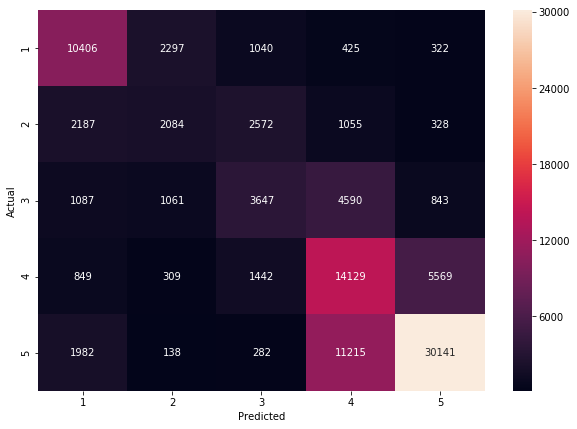

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({0: 60407, 1: 30933, 2: 4616, 4: 2304, 3: 1740})

### Looking for relation between text length and rating
Tests with charts

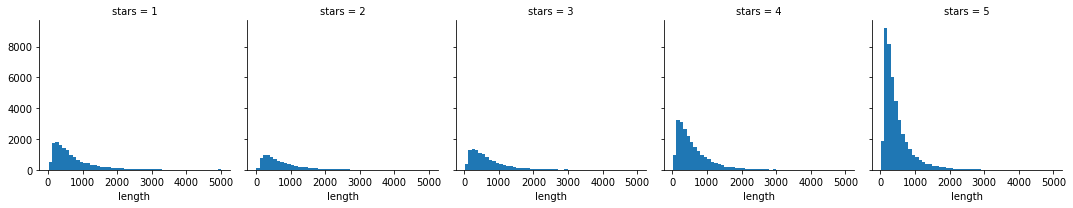

In [13]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

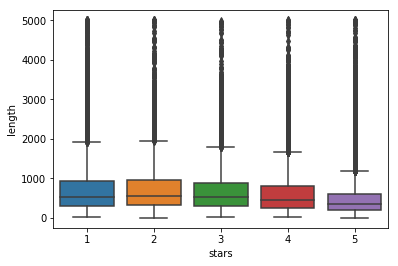

In [14]:
sns.boxplot(x='stars', y='length', data=df_test)

In [15]:
df_test.describe()

,stars,useful,funny,cool,length
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.726080,1.334980,0.461370,0.560660,598.704690
std,1.451891,3.071183,1.693002,2.061301,559.778146
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,238.000000
50%,4.000000,0.000000,0.000000,0.000000,425.000000
75%,5.000000,2.000000,0.000000,1.000000,761.000000
max,5.000000,201.000000,146.000000,203.000000,5000.000000


In [16]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['cleaned_text'] / df_train.shape[0] * 100
starProp_train


,text,cleaned_text,percentage
stars,,,
1,58491,58491,14.62275
2,32410,32410,8.10250
3,44218,44218,11.05450
4,88287,88287,22.07175
5,176594,176594,44.14850


In [17]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['cleaned_text'] / df_test.shape[0] * 100
starProp_test


,text,cleaned_text,percentage
stars,,,
1,14490,14490,14.490
2,8226,8226,8.226
3,11228,11228,11.228
4,22298,22298,22.298
5,43758,43758,43.758


Training and test set have same proportions! :-)

In [18]:
df_test['cleaned_text'].values[4]

'overall very average compared to the hype not sure if it was just a bad store of the chain but the bagels sandwiches and cafe selections were what i would expect from a cheap express stop bagels did not taste fresh and were thindry the club sandwich was okay and the mango  tasted like cheap filter slightly dissapointed maybe the spots closer to montreal are more promising for their famous bagels'

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>

In [19]:
df_train

,text,stars,useful,funny,cool,length,cleaned_text
0,Total bill for this horrible service? Over $8G...,1,6,1,0,204,total bill for this horrible service over 8gs ...
1,I *adore* Travis at the Hard Rock's new Kelly ...,5,0,0,0,1561,i adore travis at the hard rock new kelly card...
2,I have to say that this office really has it t...,5,3,0,0,615,i have to say that this office really has it t...
3,Went in for a lunch. Steak sandwich was delici...,5,0,0,0,407,went in for a lunch steak sandwich was delicio...
4,Today was my second out of three sessions I ha...,1,7,0,0,3509,today was my second out of three sessions i ha...
5,I'll be the first to admit that I was not exci...,4,0,0,0,1547,i will be the first to admit that i was not ex...
6,Tracy dessert had a big name in Hong Kong and ...,3,5,4,5,1274,tracy dessert had a big name in hong kong and ...
7,This place has gone down hill. Clearly they h...,1,3,1,1,374,this place has gone down hill clearly they ha...
8,I was really looking forward to visiting after...,2,1,0,0,1423,i was really looking forward to visiting after...
9,It's a giant Best Buy with 66 registers. I do...,3,1,0,1,97,it a giant best buy with 66 registers i do no...


In [33]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

stemmer = SnowballStemmer('english')

review = tokenizer.tokenize(df_test['cleaned_text'].values[4])
stemmed =[]
for word in review:
    stemmed = stemmed + ' ' +stemmer.stem(word)
stemmed


TypeError: can only concatenate list (not "str") to list

In [23]:
df_test['cleaned_text'].values[4]

'overall very average compared to the hype not sure if it was just a bad store of the chain but the bagels sandwiches and cafe selections were what i would expect from a cheap express stop bagels did not taste fresh and were thindry the club sandwich was okay and the mango  tasted like cheap filter slightly dissapointed maybe the spots closer to montreal are more promising for their famous bagels'